In [1]:
 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
 


E0000 00:00:1746715401.616531      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746715401.728926      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set paths for the data
base_dir = '/kaggle/input/real-life-violence-situations/new_violence'  
violent_dir = os.path.join(base_dir, 'violence')
nonviolent_dir = os.path.join(base_dir, 'non_violence')

In [3]:
# 1. Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 9413 images belonging to 2 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1660 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 11073 images belonging to 2 classes.


In [8]:
from sklearn.utils import class_weight

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights_array[i] for i in range(2)}

# MobileNetV2

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

inputs = layers.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


I0000 00:00:1746715441.203378      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746715441.204095      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Callbacks 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

In [11]:
# Train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746715455.804413      84 service.cc:148] XLA service 0x7afd580049a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746715455.805937      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746715455.805959      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746715456.843300      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/295 ━━━━━━━━━━━━━━━━━━━━ 1:22:48 17s/step - accuracy: 0.5625 - loss: 0.8719

I0000 00:00:1746715461.777026      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 154s 466ms/step - accuracy: 0.6407 - loss: 0.7285 - val_accuracy: 0.8313 - val_loss: 0.3913 - learning_rate: 1.0000e-04
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.7929 - loss: 0.4887 - val_accuracy: 0.8337 - val_loss: 0.3915 - learning_rate: 1.0000e-04
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.8166 - loss: 0.4328 - val_accuracy: 0.8512 - val_loss: 0.3757 - learning_rate: 1.0000e-04
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.8303 - loss: 0.4089 - val_accuracy: 0.8560 - val_loss: 0.3452 - learning_rate: 1.0000e-04
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.8510 - loss: 0.3704 - val_accuracy: 0.8633 - val_loss: 0.3540 - learning_rate: 1.0000e-04
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.8519 - loss: 0.3565 - val_accuracy: 0.8633 - val_loss: 0.3457 - learning_rate: 1.0000e-04
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step -

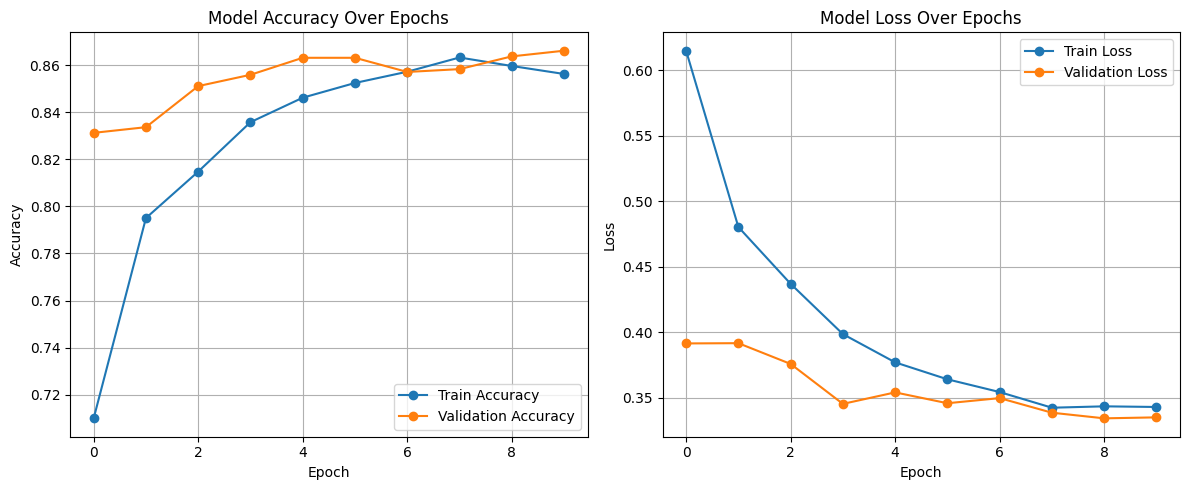

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [13]:
# Save the model
model.save('model.h5')

In [14]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Print Test Accuracy as a percentage with 3 decimal places
print(f"Test Accuracy: {test_accuracy * 100:.3f}")


347/347 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.9410 - loss: 0.1800
Test Accuracy: 89.732


#  MobileNetV2_Fine_tune

In [15]:
# Fine-tune top 30% of base model
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:

print("Fine-tuning model...")
model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks
)



Fine-tuning model...
Epoch 1/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 259ms/step - accuracy: 0.8174 - loss: 0.4342 - val_accuracy: 0.7211 - val_loss: 0.7771 - learning_rate: 1.0000e-05
Epoch 2/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - accuracy: 0.8527 - loss: 0.3723 - val_accuracy: 0.7952 - val_loss: 0.5897 - learning_rate: 1.0000e-05
Epoch 3/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - accuracy: 0.8681 - loss: 0.3355 - val_accuracy: 0.8060 - val_loss: 0.5347 - learning_rate: 1.0000e-05
Epoch 4/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - accuracy: 0.8817 - loss: 0.3137 - val_accuracy: 0.8072 - val_loss: 0.5234 - learning_rate: 1.0000e-05
Epoch 5/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - accuracy: 0.8866 - loss: 0.3044 - val_accuracy: 0.8289 - val_loss: 0.4541 - learning_rate: 1.0000e-05


In [17]:
model.save('mobileNet_finetune.h5')

In [18]:
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.3f}%")

Final Validation Accuracy: 86.627%


# ResNet50

In [19]:
from tensorflow.keras.applications import ResNet50 

# Step 1: Set up base model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_resnet.trainable = False  # Freeze for initial training

# Step 2: Add custom layers on top
inputs = layers.Input(shape=(128, 128, 3))
x = base_model_resnet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary output

model_resnet = models.Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Compile
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [21]:
# 3. Training with Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

In [22]:
# Training
print("Training ResNet50...")
history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights,
    callbacks=callbacks
)

Training ResNet50...
Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 90s 248ms/step - accuracy: 0.5942 - loss: 0.6843 - val_accuracy: 0.5276 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 2/10
  1/294 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.7188 - loss: 0.5840

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7188 - loss: 0.5840 - val_accuracy: 0.5357 - val_loss: 0.8021 - learning_rate: 0.0010
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.6405 - loss: 0.6299 - val_accuracy: 0.5300 - val_loss: 0.7497 - learning_rate: 0.0010
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.6250 - loss: 0.6082 - val_accuracy: 0.5714 - val_loss: 0.8278 - learning_rate: 0.0010
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - accuracy: 0.6456 - loss: 0.6228 - val_accuracy: 0.5319 - val_loss: 1.1746 - learning_rate: 0.0010
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.5938 - loss: 0.6214 - val_accuracy: 0.4286 - val_loss: 1.3164 - learning_rate: 0.0010
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - accuracy: 0.6530 - loss: 0.6216 - val_accuracy: 0.5398 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.6875 - loss: 0.59

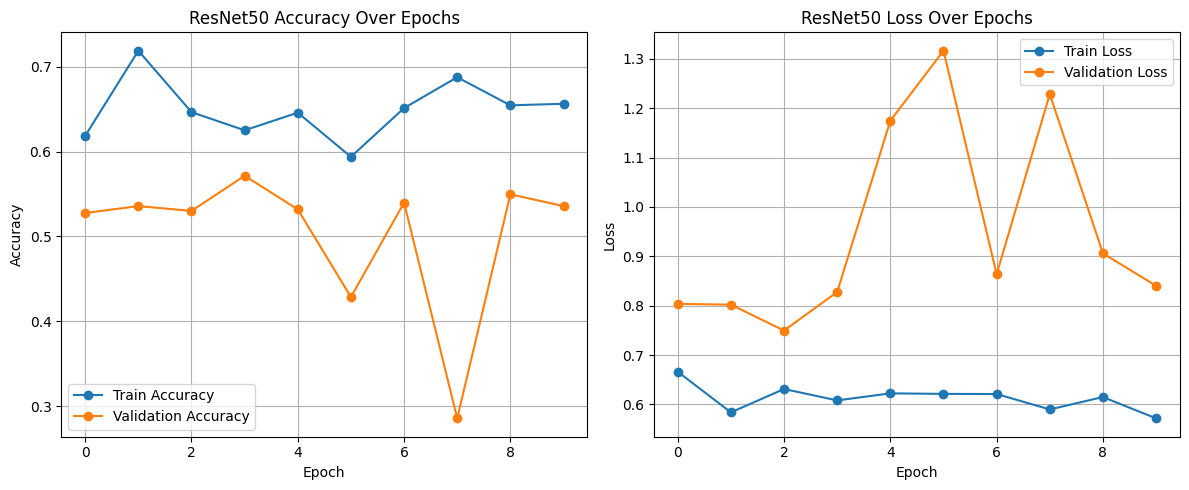

In [23]:
import matplotlib.pyplot as plt

def plot_resnet_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('ResNet50 Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('ResNet50 Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_resnet_history(history_resnet)


# Fine-tuning ResNet50...

In [24]:
# Step 6: Unfreeze and fine-tune
print("Fine-tuning ResNet50...")
base_model_resnet.trainable = True

model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Fine-tuning ResNet50...


In [25]:
history_finetune = model_resnet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 163s 310ms/step - accuracy: 0.6632 - loss: 0.6991 - val_accuracy: 0.5024 - val_loss: 1.0691 - learning_rate: 1.0000e-05
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.8342 - loss: 0.3711 - val_accuracy: 0.6084 - val_loss: 0.6911 - learning_rate: 1.0000e-05
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8802 - loss: 0.2848 - val_accuracy: 0.7958 - val_loss: 0.4929 - learning_rate: 1.0000e-05
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.9051 - loss: 0.2245 - val_accuracy: 0.8651 - val_loss: 0.3722 - learning_rate: 1.0000e-05
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.9212 - loss: 0.1984 - val_accuracy: 0.8825 - val_loss: 0.3287 - learning_rate: 1.0000e-05
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 226ms/step - accuracy: 0.9325 - loss: 0.1707 - val_accuracy: 0.8892 - val_loss: 0.3289 - learning_rate: 1.0000e-05
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 2

In [26]:

def evaluate_model(model, generator, name):
    test_loss, test_accuracy = model.evaluate(generator)
    print(f"{name} Test Accuracy: {test_accuracy*100:.4f}")
    
    y_pred = model.predict(generator)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = generator.classes[:len(y_pred_classes)]
    
    print(f"\nClassification Report for {name}:\n", classification_report(y_true, y_pred_classes))
    
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

347/347 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.9728 - loss: 0.0855
Fine-tuned ResNet50 Test Accuracy: 96.6495
347/347 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step

Classification Report for Fine-tuned ResNet50:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      5231
           1       0.99      0.95      0.97      5842

    accuracy                           0.97     11073
   macro avg       0.97      0.97      0.97     11073
weighted avg       0.97      0.97      0.97     11073



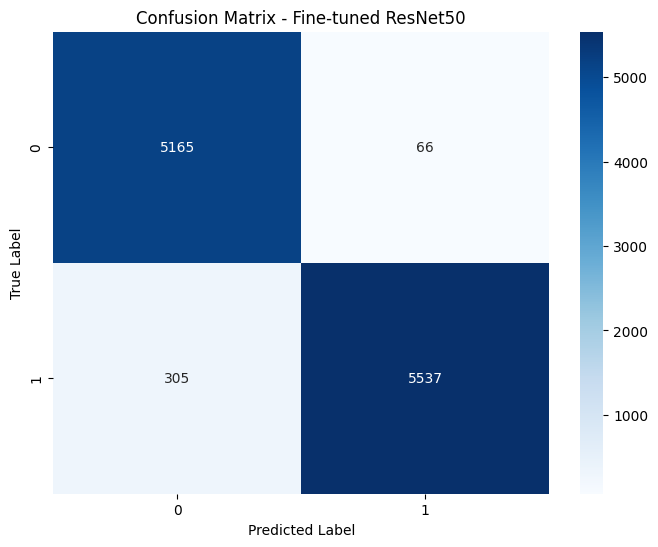

In [27]:
evaluate_model(model_resnet, test_generator, "Fine-tuned ResNet50")

In [28]:
model.save("resnet50_finetuned_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


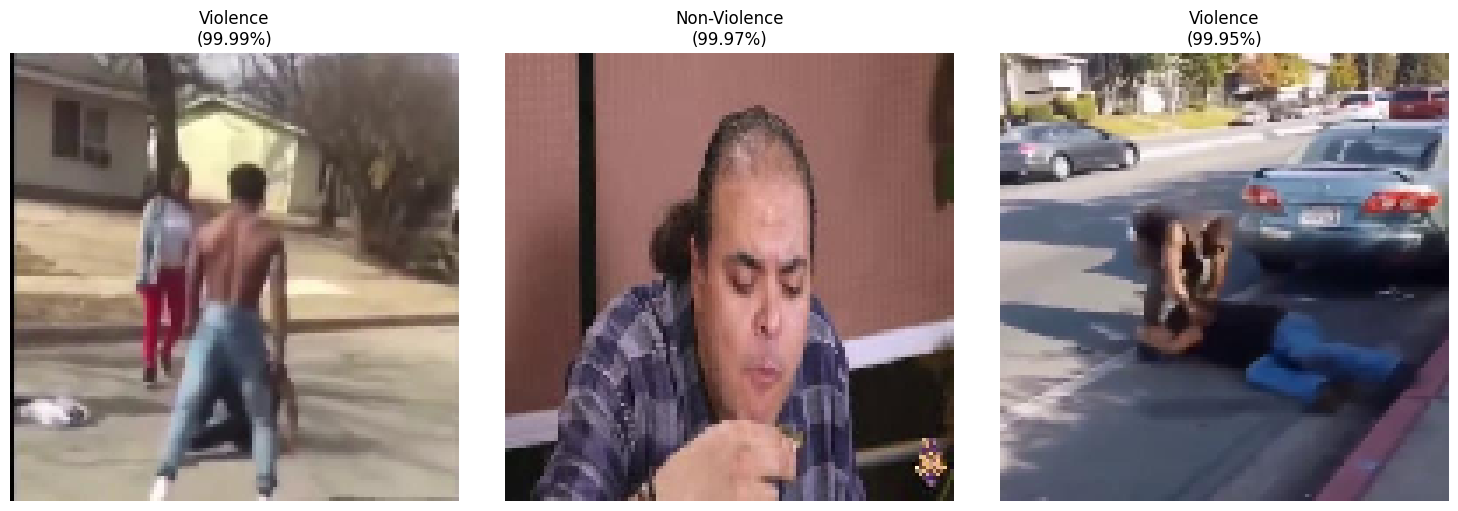

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model = load_model("/kaggle/working/resnet50_finetuned_model.h5")

image_paths = [
    "/kaggle/input/real-life-violence-situations/new_violence/violence/1.jpg", 
    "/kaggle/input/real-life-violence-situations/new_violence/non_violence/102.jpg",
    "/kaggle/input/real-life-violence-situations/new_violence/violence/100.jpg"
]


plt.figure(figsize=(15, 5))

for idx, img_path in enumerate(image_paths):
    
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    label = "Violence" if prediction >= 0.5 else "Non-Violence"
    confidence = prediction * 100 if prediction >= 0.5 else (1 - prediction) * 100

    # Plot image and prediction
    plt.subplot(1, 3, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\n({confidence:.2f}%)")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


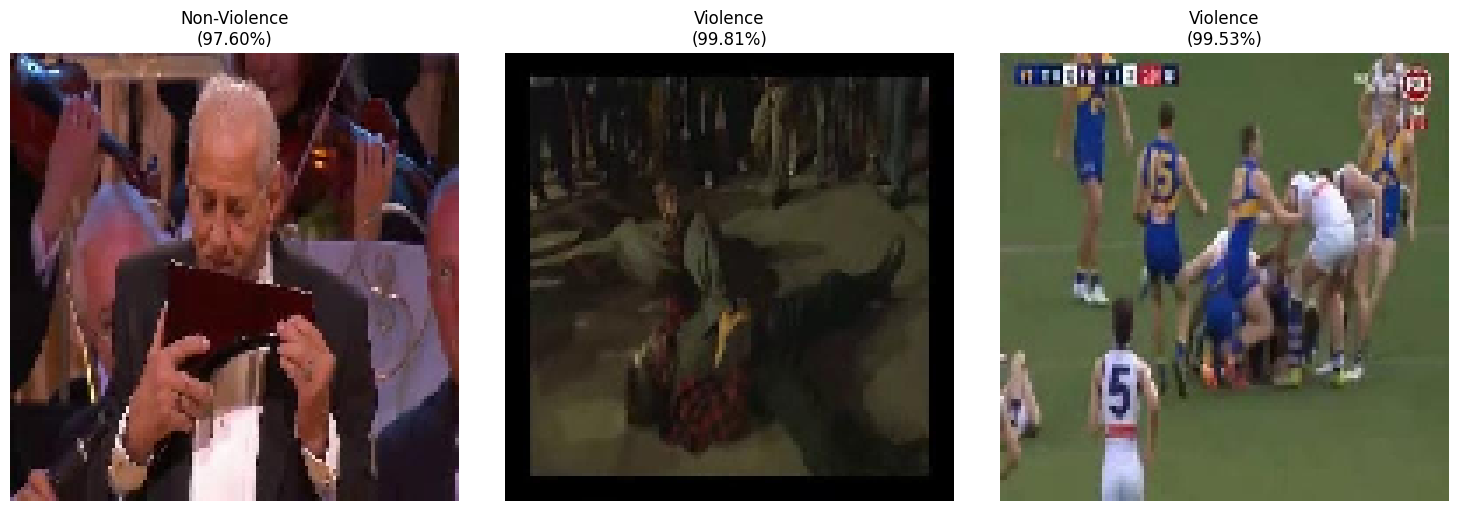

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model = load_model("resnet50_finetuned_model.h5")

image_paths = [
    "/kaggle/input/real-life-violence-situations/new_violence/non_violence/1011.jpg", 
    "/kaggle/input/real-life-violence-situations/new_violence/violence/1129.jpg",
    "/kaggle/input/real-life-violence-situations/new_violence/violence/1001.jpg"
]


plt.figure(figsize=(15, 5))

for idx, img_path in enumerate(image_paths):
    
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    label = "Violence" if prediction >= 0.5 else "Non-Violence"
    #threshold >= 0.5 -> violence else non-violence , confidence = predicton * 100
    confidence = prediction * 100 if prediction >= 0.5 else (1 - prediction) * 100 

    
    plt.subplot(1, 3, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\n({confidence:.2f}%)")

plt.tight_layout()
plt.show()
